### Fig 4d and Supp. Fig 7: SNR sweep of methods

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, re, glob


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import FIG_DIR, DATA_DIR
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
from RTI_utils import RTI
import simulation_utils 
from simulation import simulateBCIFitts


# for a reproducible result
np.random.seed(1)

fig_path = FIG_DIR
data_dir = f'{DATA_DIR}/simulator/performance/SNR/'

In [2]:
labels = ['supervised', 'HMM', 'Click HMM', 'RTI']

files  = glob.glob(os.path.join(data_dir, '*.npy'))
idxs   = [int(re.findall('_(\d+).npy', x)[0]) for x in files]
print('Missing:', np.setdiff1d(np.arange(max(idxs)), idxs))

rep_data = list()
for f in files:
    rep_data.extend(np.load(f, allow_pickle=True))
    break

Missing: []


In [3]:
labels = ['supervised', 'HMM', 'Click HMM', 'RTI']

files  = glob.glob(os.path.join(data_dir, '*.npy'))
idxs   = [int(re.findall('_(\d+).npy', x)[0]) for x in files]
print('Missing:', np.setdiff1d(np.arange(max(idxs)), idxs))

rep_data = list()
for f in files:
    rep_data.extend(np.load(f, allow_pickle=True))


# relabel methods based on HPs:
opts = np.asarray([0.077, 0.12, 0.17, 0.24, 0.31, 0.39, 0.48])
for x in rep_data:
    # there's some small variability in SNR scores - we'll discretize into bins
    snr_val  = np.linalg.norm(x['neuralTuning'][1:, :])**2
    idx      = np.argmin(np.abs(snr_val - opts))
    x['SNR'] = opts[idx]
                    
    x['SNR_val'] = snr_val # record exact SNR too
    
    if x['method'] == 'RTI' and x['look_back'] == 500:
        x['method'] = 'RTI (long look_back)'
    
    elif x['method'] == 'PRI-T' and x['click_inflection'] != None:
        x['method'] = 'Click PRI-T'
    
    else:
        continue

df = pd.DataFrame(rep_data, columns=['ttt','method','chained', 'SNR', 'SNR_val'])
df['Trial time (sec)'] = np.vstack(df['ttt'])[:, -1]

Missing: []


<AxesSubplot: xlabel='SNR_val', ylabel='SNR'>

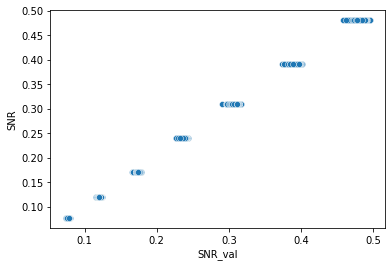

In [4]:
# just visually confirm our discretization aligns with ground-truth
sns.scatterplot(df, x='SNR_val', y='SNR')

## Vanilla HMM vs RTI comparisons

In [5]:
def makeEfficiencyPlot(df, subset_labels, colors, x = 'nSimSteps'):

    cmap      = dict(zip(subset_labels, colors))
    scores_df = df[df['method'].isin(subset_labels)]

    sns.stripplot(data = scores_df, x = x, y = 'Trial time (sec)', hue_order = subset_labels,
                  hue = 'method', alpha = 0.8, palette = cmap, dodge = True)

    ax = plt.gca()

    sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6,}, whiskerprops={'visible': False},
                zorder=1, x=x, y="Trial time (sec)", hue='method', data=scores_df, hue_order = subset_labels,
                showfliers=False, showbox=False, showcaps=False, ax=ax)

    #plt.yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(subset_labels)],labels[:len(subset_labels)], frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

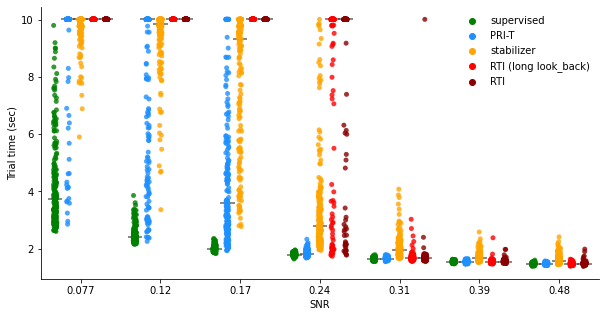

In [6]:
figSize(5, 10)

subset_labels = ['supervised', 'PRI-T', 'stabilizer', 'RTI (long look_back)', 'RTI', ]
colors = ['g', 'dodgerblue', 'orange', 'r', 'darkred', ]

makeEfficiencyPlot(df, subset_labels, colors, x = 'SNR')
plt.savefig(os.path.join(fig_path, 'simulator', 'SNR_sweep.pdf'), format = 'pdf')

<AxesSubplot: xlabel='SNR', ylabel='Trial time (sec)'>

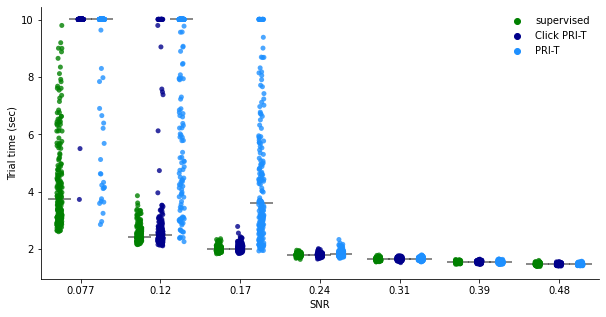

In [7]:
subset_labels = ['supervised', 'Click PRI-T', 'PRI-T']
colors = ['g', 'darkblue', 'dodgerblue', 'r']

makeEfficiencyPlot(df, subset_labels, colors, x = 'SNR')
#plt.savefig(os.path.join(fig_path, 'simulator', 'SNR_sweep_click.pdf'), format = 'pdf')

In [8]:
import scipy.stats

field = 'SNR'

subset_labels = df['method'].unique()

for nSteps in np.unique(df[field]):
    subset = df[df[field] == nSteps]
    
    print(' \n ============== ', field, ':', nSteps, '================')
    for method in subset_labels:
        times = subset.loc[subset['method'] == method, 'Trial time (sec)']
        print(f"{method:<20} Mean: {times.mean():8.3f}   Median: {times.median():8.3f}")

    print('\n')
    for i, method1 in enumerate(subset_labels):
        for j, method2 in enumerate(subset_labels):
            if i > j:
                stat = scipy.stats.ranksums(
                    subset.loc[subset['method'] == method1, 'Trial time (sec)'],
                    subset.loc[subset['method'] == method2, 'Trial time (sec)']
                )
                # Determine which method has lower values based on the sign of the statistic
                if stat[0] < 0:
                    lower = method1
                elif stat[0] > 0:
                    lower = method2
                else:
                    lower = "tie"

                print(
                    f"{method1:<20} vs {method2:<20} "
                    f"stat = {stat[0]:8.4f}   p = {stat[1]:8.4f}   lower = {lower}"
                )

 
 ==============  SNR : 0.077 ================
PRI-T                Mean:    9.441   Median:   10.020
Click PRI-T          Mean:    9.966   Median:   10.020
RTI                  Mean:   10.020   Median:   10.020
RTI (long look_back) Mean:   10.020   Median:   10.020
stabilizer           Mean:    9.736   Median:   10.020
supervised           Mean:    4.296   Median:    3.748


Click PRI-T          vs PRI-T                stat =   1.9003   p =   0.0574   lower = PRI-T
RTI                  vs PRI-T                stat =   2.0759   p =   0.0379   lower = PRI-T
RTI                  vs Click PRI-T          stat =   0.1730   p =   0.8627   lower = Click PRI-T
RTI (long look_back) vs PRI-T                stat =   2.0759   p =   0.0379   lower = PRI-T
RTI (long look_back) vs Click PRI-T          stat =   0.1730   p =   0.8627   lower = Click PRI-T
RTI (long look_back) vs RTI                  stat =   0.0000   p =   1.0000   lower = tie
stabilizer           vs PRI-T                stat =  -4.98